In [1]:
onedrive = r"C:\Users\mikek\OneDrive"

from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray as xr
import xbout
from pathlib import Path

import shutil

sys.path.append(os.path.join(onedrive,r"Project\python-packages\sdtools"))

from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *

%load_ext autoreload
%autoreload 2


print("Done")

Done


# Add core sources and transport barrier

Defining dimension z of size 1
>>> Field Nd+_src already exists in C:\Users\mikek\OneDrive\Project\collab\tech\grid\ST40\matteo-mod\g3d2f2-lores_noseam_uniformpuff.nc, it will be overwritten
-> Wrote field Nd+_src to C:\Users\mikek\OneDrive\Project\collab\tech\grid\ST40\matteo-mod\g3d2f2-lores_noseam_uniformpuff.nc
>>> Field Pd+_src already exists in C:\Users\mikek\OneDrive\Project\collab\tech\grid\ST40\matteo-mod\g3d2f2-lores_noseam_uniformpuff.nc, it will be overwritten
-> Wrote field Pd+_src to C:\Users\mikek\OneDrive\Project\collab\tech\grid\ST40\matteo-mod\g3d2f2-lores_noseam_uniformpuff.nc
>>> Field Pe_src already exists in C:\Users\mikek\OneDrive\Project\collab\tech\grid\ST40\matteo-mod\g3d2f2-lores_noseam_uniformpuff.nc, it will be overwritten
-> Wrote field Pe_src to C:\Users\mikek\OneDrive\Project\collab\tech\grid\ST40\matteo-mod\g3d2f2-lores_noseam_uniformpuff.nc
>>> Field D_d+ already exists in C:\Users\mikek\OneDrive\Project\collab\tech\grid\ST40\matteo-mod\g3d2f2-lores_no

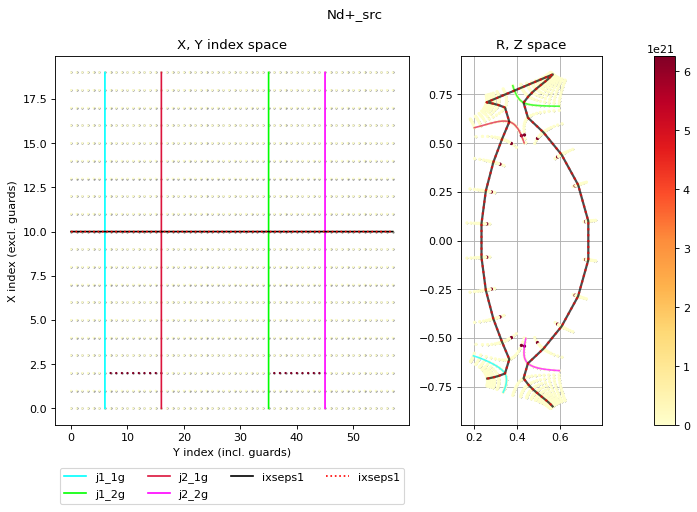

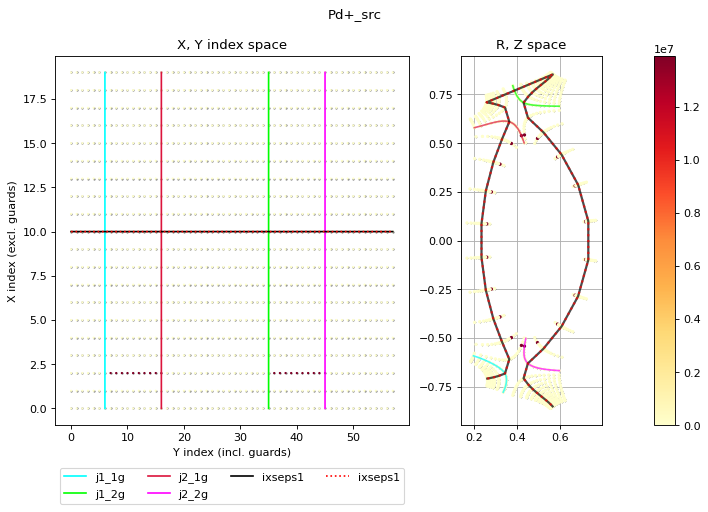

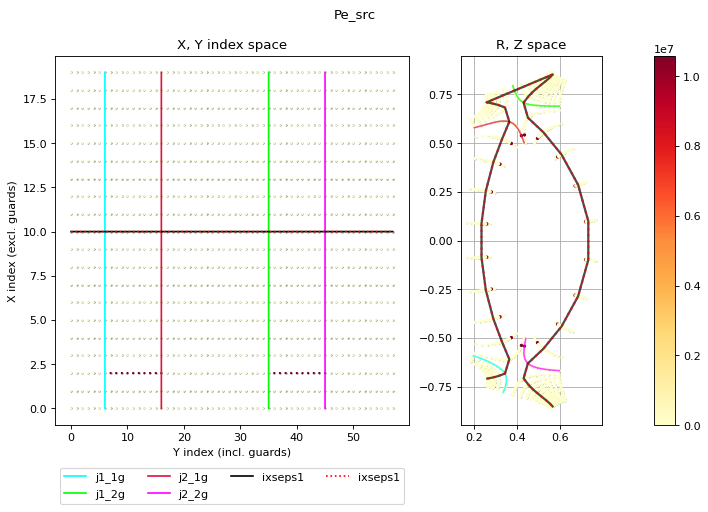

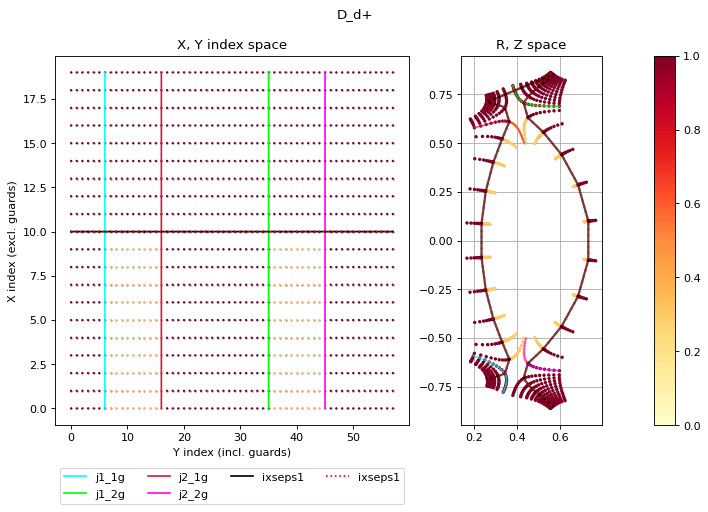

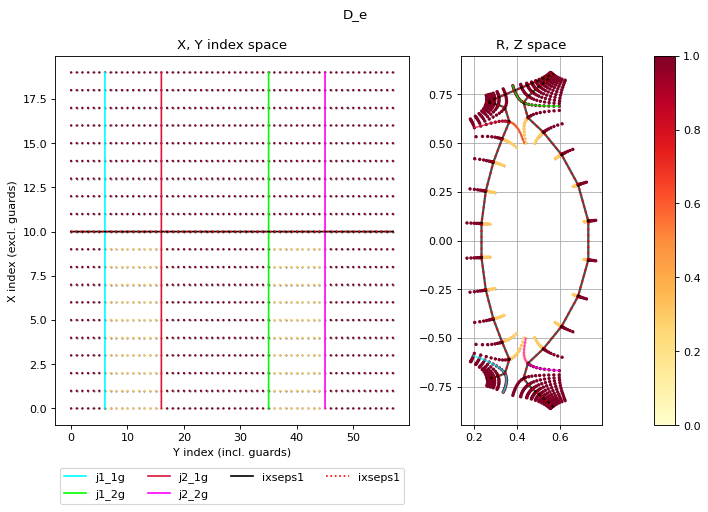

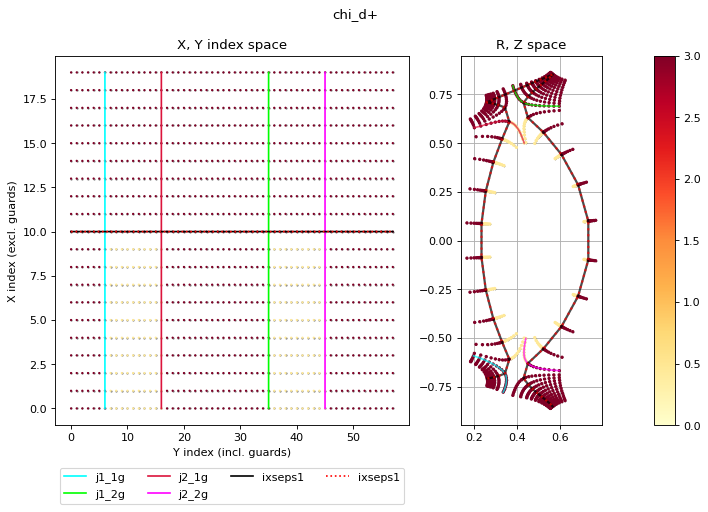

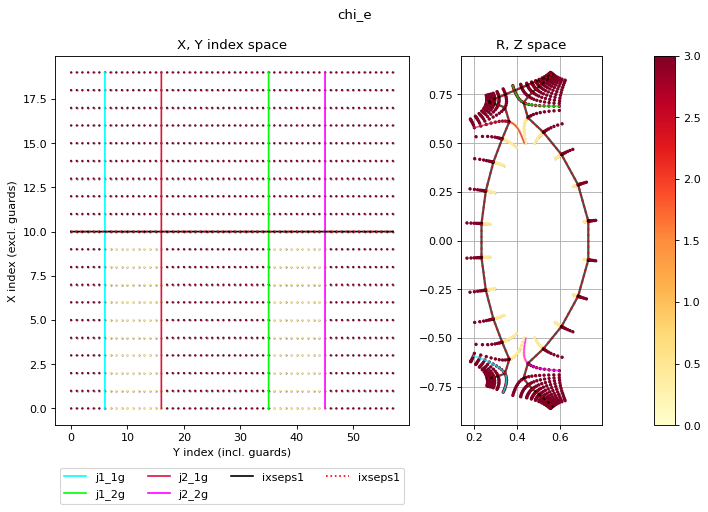

In [2]:
# close_mesh()
old_grid_path = r"C:\Users\mikek\OneDrive\Project\collab\tech\grid\ST40\matteo-mod\g3d2-lores_noseam_coarseinner.nc"
new_grid_path = r"C:\Users\mikek\OneDrive\Project\collab\tech\grid\ST40\matteo-mod\g3d2f2-lores_noseam_uniformpuff.nc"
impose_fields(
    old_grid_path,
    new_grid_path,
    Ni_src_core = 3e20,    # s-1
    Pi_src_core = 1e6 * 2/3,   # W converted to pressure
    Pe_src_core = 0.76e6 * 2/3,   # W converted to pressure
    D_core = 0.3,
    chi_core = 0.45,
    D_sol = 1,
    chi_sol = 3,
)

# Manually add puff and pump

In [4]:
mesh.j2_1g

NameError: name 'mesh' is not defined

Total flow: 1.2e+21 [s-1]
Total flow per volume: 2.03e+23 [s-1 m-3]
Total heat source: 5.77e+02 [W]
Total heat source per volume: 9.74e+04 [W m-3]
45

>>> Field Nd_src already exists in C:\Users\mikek\OneDrive\Project\collab\tech\grid\ST40\matteo-mod\g3d2f2-lores_noseam_uniformpuff.nc, it will be overwritten
-> Wrote field Nd_src to C:\Users\mikek\OneDrive\Project\collab\tech\grid\ST40\matteo-mod\g3d2f2-lores_noseam_uniformpuff.nc
>>> Field Pd_src already exists in C:\Users\mikek\OneDrive\Project\collab\tech\grid\ST40\matteo-mod\g3d2f2-lores_noseam_uniformpuff.nc, it will be overwritten
-> Wrote field Pd_src to C:\Users\mikek\OneDrive\Project\collab\tech\grid\ST40\matteo-mod\g3d2f2-lores_noseam_uniformpuff.nc
>>> Field is_pump already exists in C:\Users\mikek\OneDrive\Project\collab\tech\grid\ST40\matteo-mod\g3d2f2-lores_noseam_uniformpuff.nc, it will be overwritten
-> Wrote field is_pump to C:\Users\mikek\OneDrive\Project\collab\tech\grid\ST40\matteo-mod\g3d2f2-lores_noseam_uniformpuf

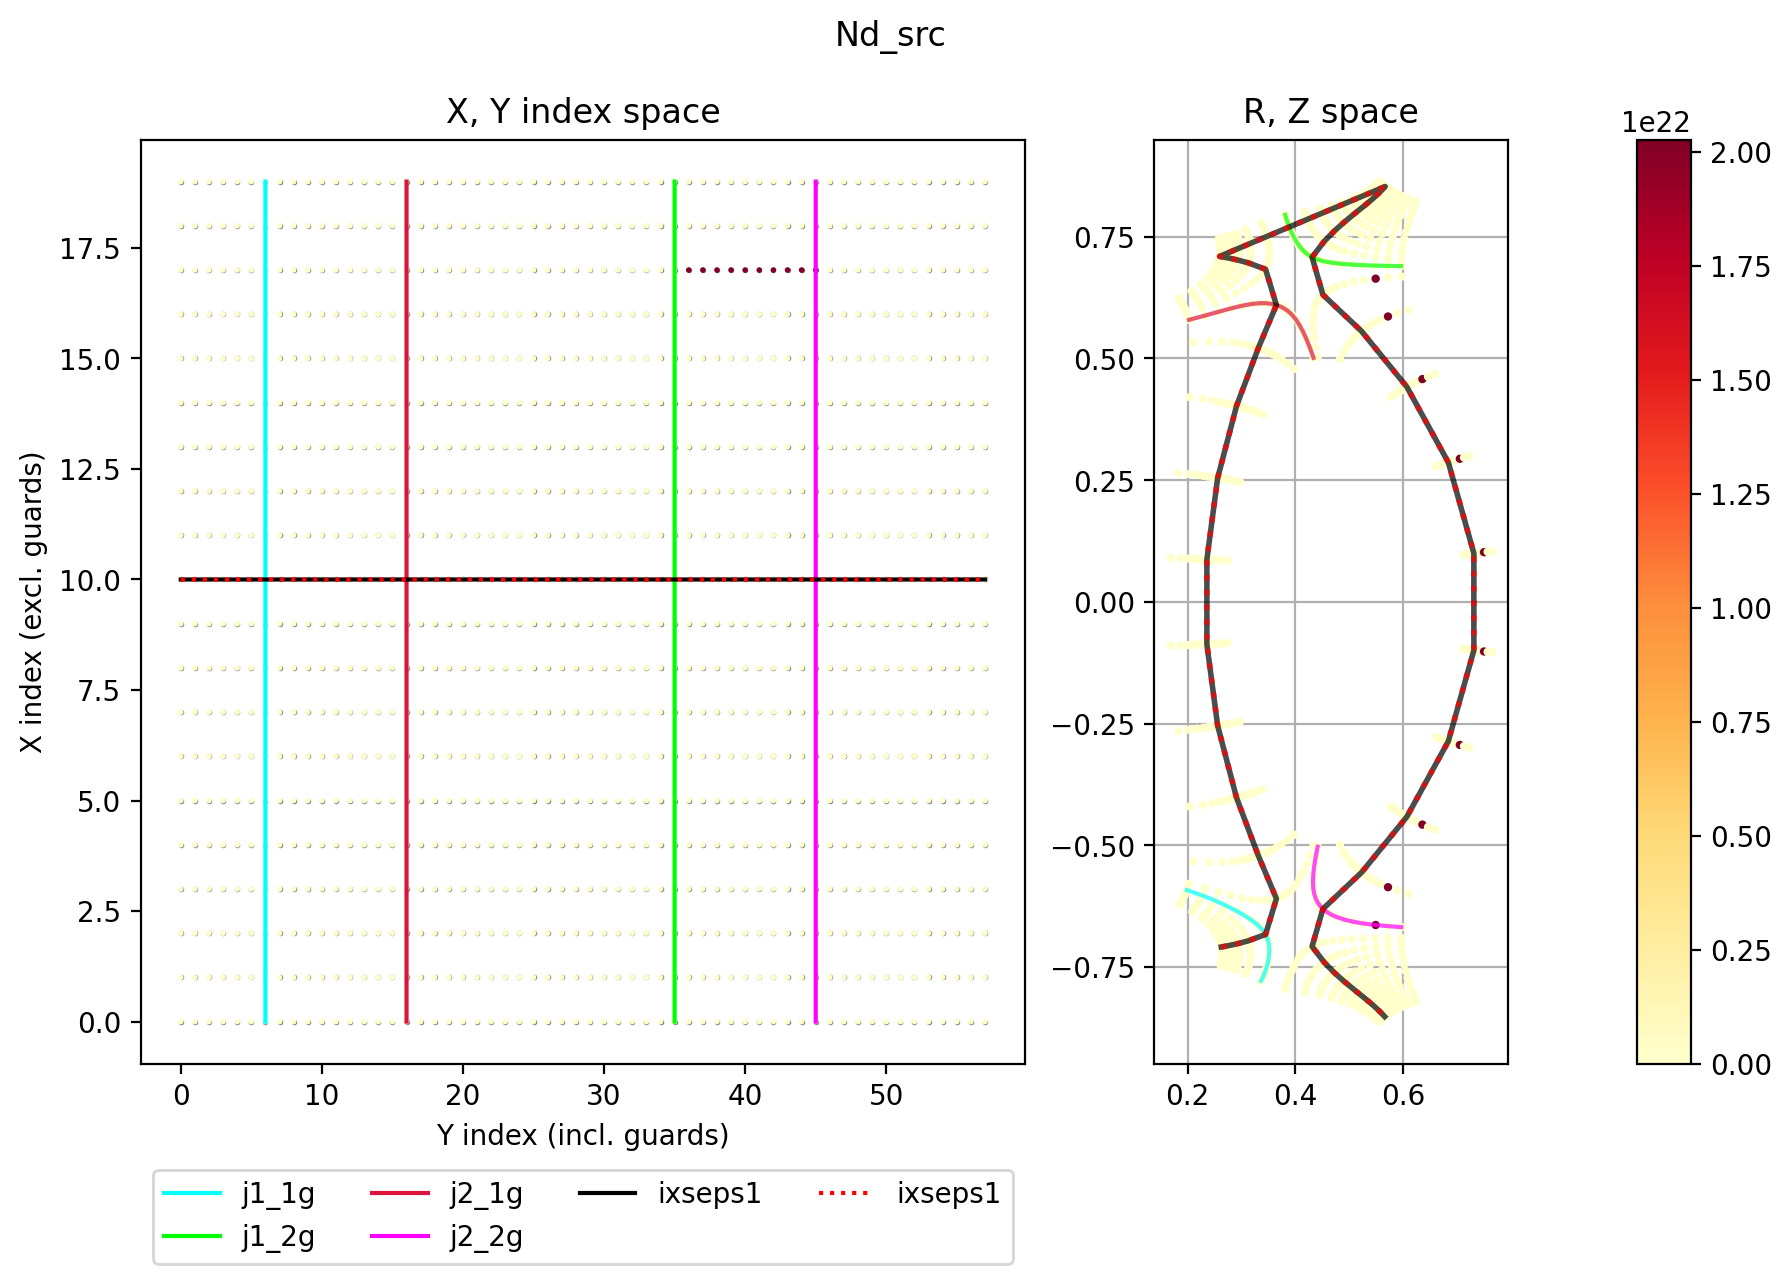

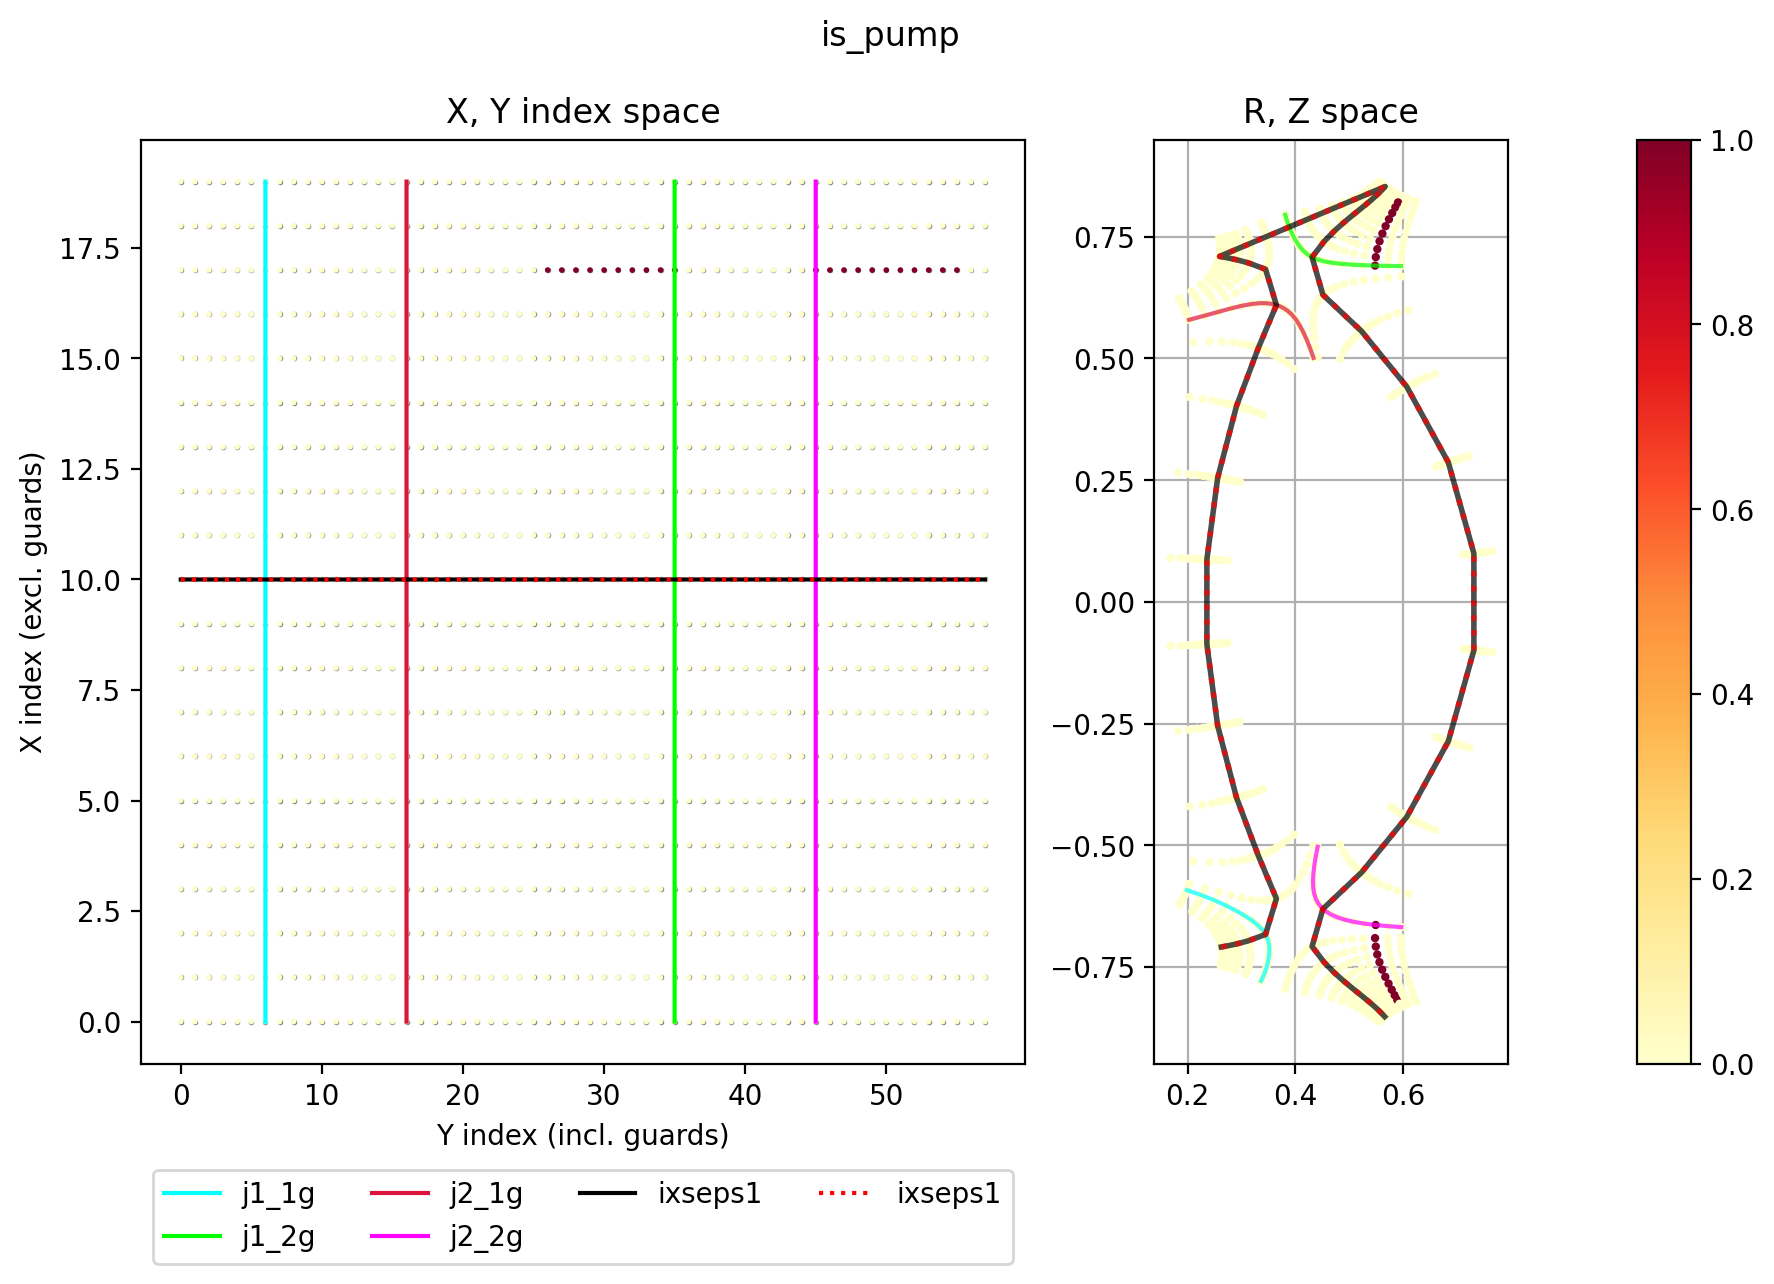

In [6]:
plt.close("all")
mesh = Mesh(new_grid_path)
self = mesh

midplane_a = int((self.j2_2g - self.j1_2g) / 2) + self.j1_2g
midplane_b = int((self.j2_2g - self.j1_2g) / 2) + self.j1_2g + 1


# puff_indices = [2, 5, 8]   # fine grid
puff_indices = [0, 1, 2, 3,4]   # SOLEDGE puff, coarse grid

selection =  (-self.MXG-1, 
            np.r_[
                [midplane_a-x for x in puff_indices],
                [midplane_b+x for x in puff_indices]
                ])
            
# puff_region = mesh.slices("symmetric_puff")(width=3, center_half_gap=1)
puff_region = selection

mesh.mesh["dv"] = mesh.mesh["dy"] * mesh.mesh["dx"] * mesh.mesh["J"] * 2*np.pi
volume = mesh.mesh["dv"][puff_region]

total_flow = 1.2e21   # atoms per second

total_flow_per_volume = total_flow * (volume/volume.sum()) / volume  # first find how much per cell, then per volume
print(f"Total flow: {total_flow} [s-1]")
print(f"Total flow per volume: {total_flow_per_volume.sum():.2e} [s-1 m-3]")

heat_source = 1.2e21 * 3 * constants("q_e")  #  3eV per particle (assume dissociated molecules)
heat_source_per_volume = heat_source * (volume/volume.sum()) / volume 
print(f"Total heat source: {heat_source:.2e} [W]")
print(f"Total heat source per volume: {heat_source_per_volume.sum():.2e} [W m-3]")

print(mesh.j2_2g)
pump_region = (-self.MXG-1, 
            np.r_[
                slice(mesh.ny_inner+mesh.MYG*3, mesh.j1_2g+1),
                slice(mesh.j2_2g, mesh.nyg-mesh.MYG*1)
                ])

Pd_src = Field("Pd_src", mesh)
Nd_src = Field("Nd_src", mesh)
is_pump = Field("is_pump", mesh)

print()

Nd_src.data[puff_region] = total_flow_per_volume
Pd_src.data[puff_region] = heat_source_per_volume
mesh.write_field(Nd_src)
mesh.write_field(Pd_src)

is_pump.data[pump_region] = 1
Nd_src.plot(dpi = 200)
is_pump.plot(dpi = 200)

mesh.write_field(is_pump, dtype = "Field2D")

try:
    mesh.close()
    del mesh
except:
    pass

In [8]:
try:
    mesh.close()
    del mesh
except:
    pass

mesh = Mesh(r"C:\Users\mikek\OneDrive\Project\collab\tech\grid\ST40\matteo-mod\g3c2-fine_xpoint_fields.nc")

pressure_source_per_volume = mesh.mesh["Pd_src"].squeeze()
density_source_per_volume = mesh.mesh["Nd_src"].squeeze()

dv = mesh.mesh["dy"] * mesh.mesh["dx"] * mesh.mesh["J"] * 2*np.pi

pressure_source = (pressure_source_per_volume * dv).sum()
density_source = (density_source_per_volume * dv).sum()

print(f"Total pressure source: {pressure_source:.2e} [W]")
print(f"Pressure source per volume: {pressure_source_per_volume.sum():.2e} [W m-3]")
print(f"Total density source: {density_source:.2e} [s-1]")
print(f"Density source per volume: {density_source_per_volume.sum():.2e} [s-1 m-3]")

try:
    mesh.close()
    del mesh
except:
    pass

Total pressure source: 5.77e+02 [W]
Pressure source per volume: 3.87e+05 [W m-3]
Total density source: 1.20e+21 [s-1]
Density source per volume: 8.06e+23 [s-1 m-3]
Mesh file C:\Users\mikek\OneDrive\Project\collab\tech\grid\ST40\matteo-mod\g3c2-fine_xpoint_fields.nc closed
